# Equilibrium climate sensitivity from 4xCO2

Reference: Gregory et al. (2004). https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2003GL018747

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import foci_functions
from scipy.stats import linregress

In [2]:
# Read CO2
exps = ['FOCI_GJK029',
        'FOCI_GJK031_r1i1p1']
names = ['piControl','abrupt-4xCO2']

ds_list = []
for i,exp in enumerate(exps):
    ds = xr.open_dataset('data/%s_forcing.nc' % (exp,), use_cftime=True)
    ds['expname'] = names[i]
    ds_list.append(ds)

In [3]:
# Read OpenIFS data
time_list = [slice('2550-01-01','2700-01-01'),
             slice('1850-01-01','2000-01-01')]

ds_sfc = foci_functions.read_openifs(exps, time_list)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK029/outdata/oifs/*1m*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK031_r1i1p1/outdata/oifs/*1m*regular_sfc.nc


In [4]:
# Compute global mean T2m
tmean_list = [] 
for ds in ds_sfc:
    tm = foci_functions.global_mean(ds['2t'])
    tmean_list.append(tm.compute())

In [5]:
# Compute global mean TOA flux
toa_list = [] 
for ds in ds_sfc:
    tm = foci_functions.global_mean((ds['tsr'] + ds['ttr'])/(6.0*3600))
    toa_list.append(tm.compute())

In [10]:
# Compute anomalies from piControl
d_toa = toa_list[1].groupby('time.year').mean('time') - toa_list[0].mean('time')
d_t2m = tmean_list[1].groupby('time.year').mean('time') - tmean_list[0].mean('time')

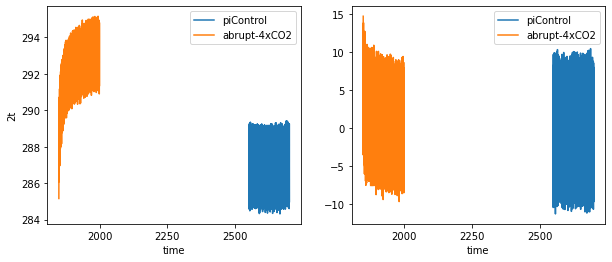

In [11]:
# Check plot
fig, ax = plt.subplots(1,2,figsize=(10,4))
for i,t2m in enumerate(tmean_list):
    t2m.plot(ax=ax[0],label=names[i])
ax[0].legend()

for i,toa in enumerate(toa_list):
    toa.plot(ax=ax[1],label=names[i])
ax[1].legend()


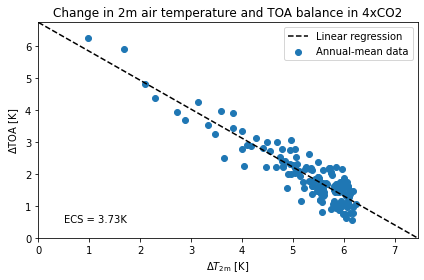

In [32]:
## The so-called Gregory plot
fig, ax = plt.subplots(1,1)
ax.scatter(d_t2m, d_toa, label='Annual-mean data')
ax.set_xlabel(r'$\Delta T_\mathrm{2m}$ [K]');
ax.set_ylabel(r'$\Delta \mathrm{TOA}$ [K]');
ax.set_title('Change in 2m air temperature and TOA balance in 4xCO2');

# Linear regression
slope, intercept, r, p, se = linregress(d_t2m.data, d_toa.data)

# Compute ECS 
# t2m where TOA = 0, divided by 2, i.e. climate response to 2xCO2
ecs = -0.5 * intercept/slope
ax.text(0.5, 0.5, 'ECS = %1.2fK' % (ecs,))

# Construct linear slope
toa_predicted = intercept + np.array([0,ecs*2]) * slope
ax.plot(np.array([0,ecs*2]), toa_predicted, '--k', label='Linear regression')
ax.legend()

ax.set_xlim([0,ecs*2])
ax.set_ylim([0,toa_predicted[0]])
fig.tight_layout()
fig.savefig('gregory_plot.pdf',format='pdf')